# PyTorch Demo

# Imports & Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader

from torchvision.datasets import MNIST
from torchvision import transforms

from sklearn.metrics import confusion_matrix

### Check Cuda Availability

In [2]:
cuda_available = torch.cuda.is_available()
print(f'CUDA Available: {cuda_available}')
if cuda_available:
    print('CUDA device:', torch.cuda.get_device_name(0))

CUDA Available: True
CUDA device: NVIDIA A100-PCIE-40GB MIG 1g.5gb


# Data Loading & Preprocessing

### Dataset Transforms

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),                                 # Transform images to tensors
    lambda image: image.view(image.size(1), image.size(2)) # Remove color channel dimension, since we only have black and white
])

### Getting the data, transforming, and loading it

In [4]:
mnist_train = MNIST(root="./", train=True, download=True, transform=transform)
mnist_test = MNIST(root="./", train=False, download=True, transform=transform)

train_loader = DataLoader(mnist_train, batch_size=10000, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=10000, shuffle=True)

### Example input

In [5]:
for images, labels in test_loader:
    sample_image = images[0]
    sample_label = labels[0]
    break

print('type:', type(sample_image))
print('shape:', sample_image.shape)
print('raw data:', sample_image)

type: <class 'torch.Tensor'>
shape: torch.Size([28, 28])
raw data: tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.8275, 0.8784, 0.7098, 0.0863, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.3608, 0.6275, 0.9961, 0.8392, 0.1922, 0.00

### Example visual

sample lable: tensor(2)


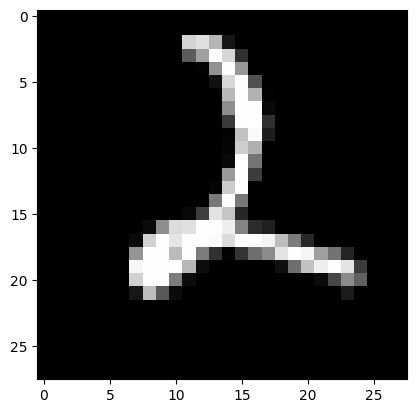

In [6]:
plt.imshow(sample_image, cmap="gray")

print('sample lable:', sample_label) # Label tensor
plt.show()

### Reshaping example

In [7]:
print('original shape:', sample_image.shape)                                                              # Original shape
print('reshaped using `view`:', sample_image.view(sample_image.size(0)*sample_image.size(1)).shape)       # View to change shape
print('reshaped using `reshape`:', sample_image.reshape(sample_image.size(0)*sample_image.size(1)).shape) # Reshape to change shape
print('reshaped using `flatten`:', sample_image.flatten().shape)                                          # Flatten to change shape

original shape: torch.Size([28, 28])
reshaped using `view`: torch.Size([784])
reshaped using `reshape`: torch.Size([784])
reshaped using `flatten`: torch.Size([784])


# Neural Network Model

In [8]:
class Model(nn.Module):
    # Model initialization
    def __init__(self):
        super(Model, self).__init__()

        # Hidden layer initialization
        self.hidden1 = nn.Linear(28*28, 100)
        self.hidden2 = nn.Linear(100, 100)
        self.hidden3 = nn.Linear(100, 100)

        # Output layer initialization
        self.out = nn.Linear(100, 10)

        # Activation functions
        self.relu = nn.ReLU()            # ReLU activation function used on hidden layers
        self.softmax = nn.Softmax(dim=1) # SoftMax activation function used on output layer; All values in [0,1] and must sum to 1
        
    # Model operation
    def forward(self, x):
        h1 = self.relu(self.hidden1(x))   # hidden layer 1, relu activation
        h2 = self.relu(self.hidden2(h1))  # hidden layer 2, relu activation
        h3 = self.relu(self.hidden3(h2))  # hidden layer 3, relu activation
        return self.softmax(self.out(h3)) # output layer, softmax activation function

### Model Initialization

In [9]:
model = Model()
if cuda_available:
    model.cuda()

print(model)

Model(
  (hidden1): Linear(in_features=784, out_features=100, bias=True)
  (hidden2): Linear(in_features=100, out_features=100, bias=True)
  (hidden3): Linear(in_features=100, out_features=100, bias=True)
  (out): Linear(in_features=100, out_features=10, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=1)
)


### Training Protocol Initialization

In [10]:
counts = np.unique(mnist_train.targets, return_counts=True)[1] # get number of occurrences of each label
weights = torch.from_numpy(np.max(counts)/counts).float()      # compute relative weights for each label

if cuda_available:
    weights = weights.cuda()
    
print('label counts:', counts)
print('class weights:', weights)

label counts: [5923 6742 5958 6131 5842 5421 5918 6265 5851 5949]
class weights: tensor([1.1383, 1.0000, 1.1316, 1.0997, 1.1541, 1.2437, 1.1392, 1.0761, 1.1523,
        1.1333], device='cuda:0')


In [11]:
criterion = nn.CrossEntropyLoss(weight=weights)       # Loss function
optim = torch.optim.Adam(model.parameters(), lr=1e-3) # Optimizer

# Learning Rate scheduler (OPTIONAL)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, factor=0.1, patience=5, verbose=True)

# Model Training

### Defining training function

In [12]:
# Run a single epoch
def run_epoch(train):
    if train:
        model.train()
        loader = train_loader
    else:
        model.eval()
        loader = test_loader

    # LOGGING
    total_loss = 0.                # Total epoch loss
    confusion = np.zeros((10, 10)) # Used for tracking accuracy (10 because of 10 labels)

    for x, y in loader:
        if cuda_available: # Move tensors over to cuda if present
            x = x.cuda()
            y = y.cuda()

        # Data in the loader is 28x28, but our model expects a flattened tensor
        x = x.flatten(start_dim=1, end_dim=2)

        # Put data through model, get predictions. This calls the forward() function!
        predictions = model(x)

        # Calculate loss (how wrong our predictions are)
        loss = criterion(predictions, y)

        if train:
            optim.zero_grad() # Reset gradients
            loss.backward()   # Calculate new gradients
            optim.step()      # Run optimizer & update weights and biases

        # LOGGING
        total_loss += loss.item() * predictions.size(0)
        confusion += confusion_matrix(y.cpu(), predictions.argmax(dim=1).cpu(), labels=range(10))

    if not train:
        scheduler.step(total_loss) # Run learning rate scheduler on

    return total_loss / len(loader.dataset), \
           confusion.diagonal().sum() / confusion.sum(), \
           (confusion.diagonal() / confusion.sum(axis=1)).mean()

### Training

In [13]:
epochs = 50
print_frequency = 5

In [14]:
train_losses = []
test_losses = []

train_accuracies = []
test_accuracies = []

train_balanced_accuracies = []
test_balanced_accuracies = []

for e in range(epochs):
    train_loss, train_accuracy, train_balanced_accuracy = run_epoch(True) # Train model
    test_loss, test_accuracy, test_balanced_accuracy = run_epoch(False)   # Test model
    
    # Performance tracking
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    train_balanced_accuracies.append(train_balanced_accuracy)
    test_balanced_accuracies.append(test_balanced_accuracy)
    
    if (e+1) % print_frequency == 0:
        epoch_counter = f'Epoch: {" " * (len(str(epochs)) - len(str(e + 1)))}{e + 1}/{epochs}'
        print('----------------------------------------------------------------------------------------------------')
        print(f'{epoch_counter} | Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy:.4f} | Train Balanced Accuracy: {train_balanced_accuracy:.4f}')
        print(f'{" " * len(epoch_counter)} |  Test Loss: {test_loss:.4f} |  Test Accuracy: {test_accuracy:.4f} |  Test Balanced Accuracy: {test_balanced_accuracy:.4f}')
                
    scheduler.step(test_loss)

print('----------------------------------------------------------------------------------------------------')

----------------------------------------------------------------------------------------------------
Epoch:   5/100 | Train Loss: 1.9832 | Train Accuracy: 0.5532 | Train Balanced Accuracy: 0.5460
               |  Test Loss: 1.8949 |  Test Accuracy: 0.6625 |  Test Balanced Accuracy: 0.6550
----------------------------------------------------------------------------------------------------
Epoch:  10/100 | Train Loss: 1.6124 | Train Accuracy: 0.8720 | Train Balanced Accuracy: 0.8700
               |  Test Loss: 1.5978 |  Test Accuracy: 0.8825 |  Test Balanced Accuracy: 0.8805
----------------------------------------------------------------------------------------------------
Epoch:  15/100 | Train Loss: 1.5690 | Train Accuracy: 0.9035 | Train Balanced Accuracy: 0.9023
               |  Test Loss: 1.5651 |  Test Accuracy: 0.9053 |  Test Balanced Accuracy: 0.9039
----------------------------------------------------------------------------------------------------
Epoch:  20/100 | Train Los

# Performance plots

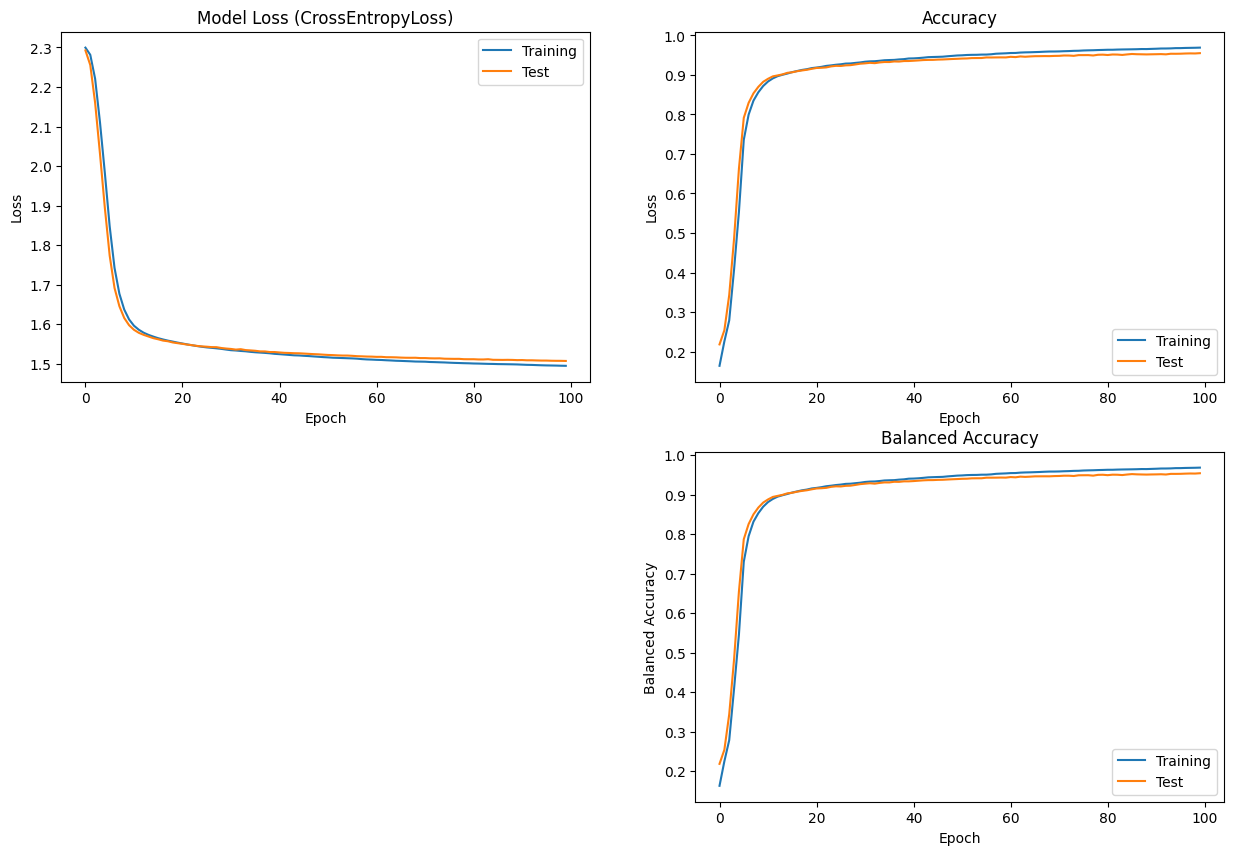

In [15]:
fig, axs = plt.subplots(2,2,figsize=(15,10))

# Loss
axs[0,0].plot(train_losses, label='Training')
axs[0,0].plot(test_losses, label='Test')
axs[0,0].legend()
axs[0,0].set_title(f'Model Loss ({criterion.__class__.__name__})')
axs[0,0].set_xlabel('Epoch')
axs[0,0].set_ylabel('Loss')

# Accuracy
axs[0,1].plot(train_accuracies, label='Training')
axs[0,1].plot(test_accuracies, label='Test')
axs[0,1].legend()
axs[0,1].set_title('Accuracy')
axs[0,1].set_xlabel('Epoch')
axs[0,1].set_ylabel('Loss')

# Balanced Accuracy
axs[1,1].plot(train_balanced_accuracies, label='Training')
axs[1,1].plot(test_balanced_accuracies, label='Test')
axs[1,1].legend()
axs[1,1].set_title('Balanced Accuracy')
axs[1,1].set_xlabel('Epoch')
axs[1,1].set_ylabel('Balanced Accuracy')

fig.delaxes(axs[1,0])

plt.show()